In [1]:
import training
import numpy as np
from model_selection import rank_models, plot_model_losses, haversine_np
from save_results import load_scaler, plot_samples
import files
import pickle

In [2]:
device = training.determine_device()
print("Using device:", device)

Using device: cpu


In [3]:
metrics = ["val_mse", "val_rmse", "val_mae"]
results = files.Results(filtered=True)

# Use one of the values above
metric = "val_mse"

assert metric in metrics
best_model_name, best_score, best_model_data = rank_models(results, metric)

Best validation MSE per model (sorted): 

1. deeper_autoreg_lstm_2          best MSE = 0.000294
2. deeper_autoreg_lstm            best MSE = 0.000301
3. medium_autoreg_lstm            best MSE = 0.000308
4. deeper_lstm_2                  best MSE = 0.000315
5. deeper_lstm                    best MSE = 0.000320
6. even_deeper_lstm               best MSE = 0.000325
7. small_autoreg_lstm             best MSE = 0.000331
8. medium_lstm                    best MSE = 0.000334
9. small_lstm                     best MSE = 0.000352
10. deeper_transformer             best MSE = 0.000360
11. deeper_transformer_3           best MSE = 0.000367
12. small_seq2seq_trans            best MSE = 0.000431
13. mini_lstm                      best MSE = 0.000434
14. mini_autoreg_lstm              best MSE = 0.000468
15. small_transformer              best MSE = 0.000469
16. mini_transformer               best MSE = 0.000494
17. mini_seq2seq_trans             best MSE = 0.000647
18. medium_transformer          

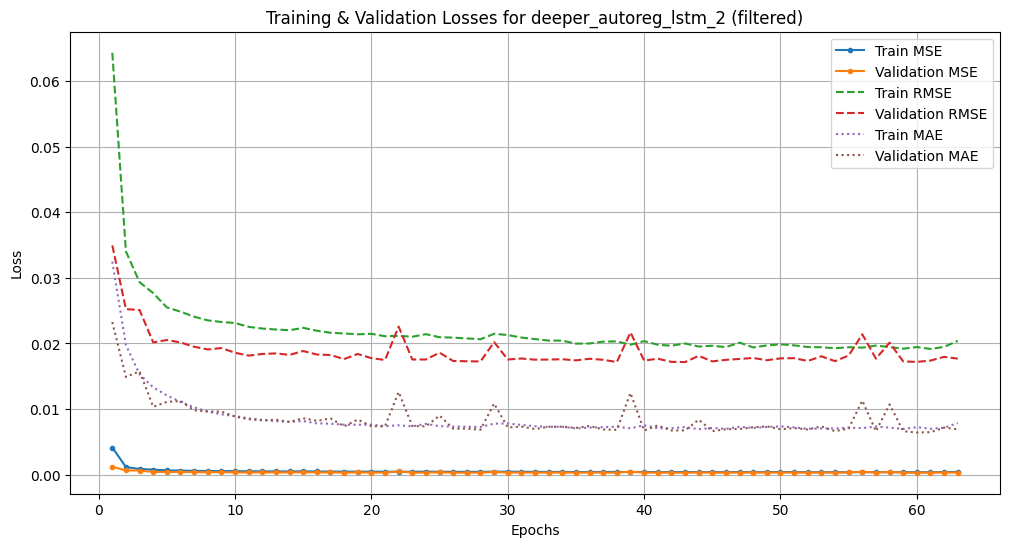

In [4]:
# plot losses for the best model based on MSE

plot_model_losses(best_model_data)

In [5]:
metrics = files.Metrics()

### Results for the best model: Deep Autoregressive LSTM 2 (on the test set)

In [6]:
file_path = metrics.pkl("deeper_autoreg_lstm_2", "test")

# Open the pickle file
with open(file_path, 'rb') as file:
    results = pickle.load(file)


In [7]:
all_mse = results["all_mse"]
x = results["x"]
y = results["y"]
y_pred = results["y_pred"]
n_samples = len(all_mse)
sorted_indices = np.argsort(all_mse)

In [8]:
percentiles = [10, 30, 50, 80, 90, 95, 99, 99.99, 100]
print("\nMSE percentile summary:\n")
for p in percentiles:
    threshold = np.percentile(all_mse, p)
    print(f"{p:>3}% of samples have MSE ≤ {threshold:.6f}")


MSE percentile summary:

 10% of samples have MSE ≤ 0.000006
 30% of samples have MSE ≤ 0.000015
 50% of samples have MSE ≤ 0.000030
 80% of samples have MSE ≤ 0.000127
 90% of samples have MSE ≤ 0.000313
 95% of samples have MSE ≤ 0.000640
 99% of samples have MSE ≤ 0.002156
99.99% of samples have MSE ≤ 0.429050
100% of samples have MSE ≤ 4.922836


In [9]:
scaler = load_scaler(filtered=True)

groups = {
    "Best": sorted_indices[:3],
    "Q1": sorted_indices[n_samples//4:n_samples//4+3],
    "Median": sorted_indices[n_samples//2:n_samples//2+3],
    "Q3": sorted_indices[3*n_samples//4:3*n_samples//4+3],
    "Worst": sorted_indices[-3:]
}

group_means_dict = {}

print("\n=== Haversine Distance Evaluation by Groups ===")

for group_name, indices in groups.items():
    group_means = []

    print(f"\n### {group_name} group ###")

    for idx in indices:

        y_true_scaled = y[idx]
        y_pred_scaled = y_pred[idx]


        y_true_unscaled = scaler.inverse_transform(y_true_scaled)
        y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

        # Compute Haversine
        dists_km, mean_hav_km = haversine_np(y_true_unscaled, y_pred_unscaled)

        # Save group mean
        group_means.append(mean_hav_km)

        # --- Pretty step-wise print for groups ---
        print(f"\nSample {idx} (MSE={all_mse[idx]:.6f}) – Haversine per step:")
        for step, d in enumerate(dists_km, start=1):
            print(f"  Step {step:02d} → {d:10.6f} km")

        print(f"  -> Mean Haversine for this sample: {mean_hav_km:.6f} km")

        group_means_dict[group_name] = group_means


=== Haversine Distance Evaluation by Groups ===

### Best group ###

Sample 358807 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.108377 km
  Step 02 →   0.014771 km
  Step 03 →   0.233176 km
  Step 04 →   0.206272 km
  Step 05 →   0.040147 km
  Step 06 →   0.207699 km
  Step 07 →   0.260574 km
  Step 08 →   0.208669 km
  Step 09 →   0.184193 km
  Step 10 →   0.152361 km
  -> Mean Haversine for this sample: 0.161624 km

Sample 269499 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.271715 km
  Step 02 →   0.209799 km
  Step 03 →   0.227926 km
  Step 04 →   0.066838 km
  Step 05 →   0.092511 km
  Step 06 →   0.079194 km
  Step 07 →   0.089335 km
  Step 08 →   0.112087 km
  Step 09 →   0.103294 km
  Step 10 →   0.088092 km
  -> Mean Haversine for this sample: 0.134079 km

Sample 16523 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.185409 km
  Step 02 →   0.144717 km
  Step 03 →   0.129129 km
  Step 04 →   0.128227 km
  Step 05 →   0.242107 km
  Step 06 →   0.112114 km
  


Plotting 3 samples from Best group:


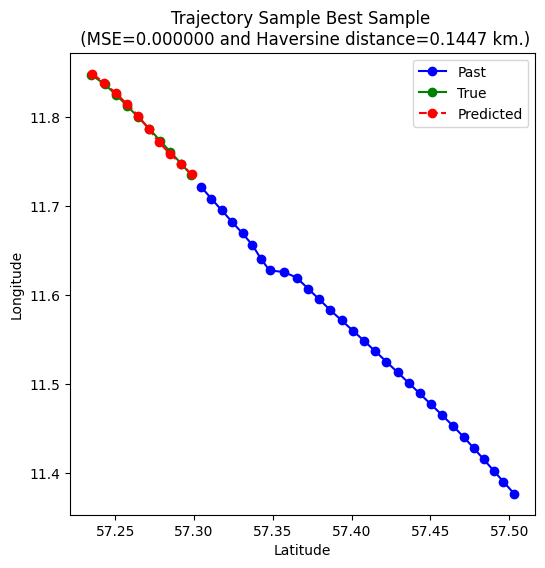

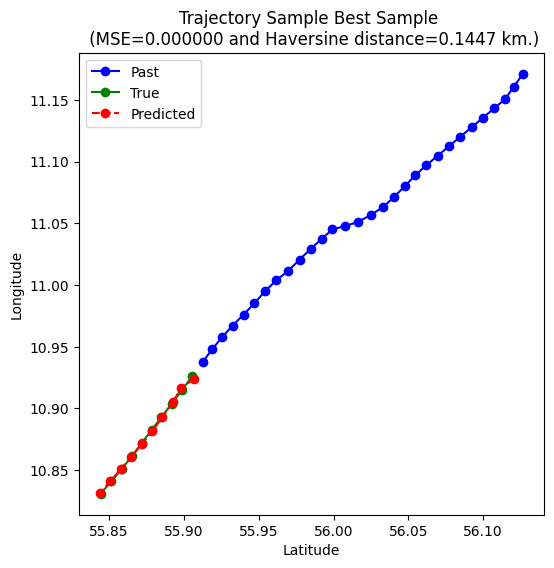

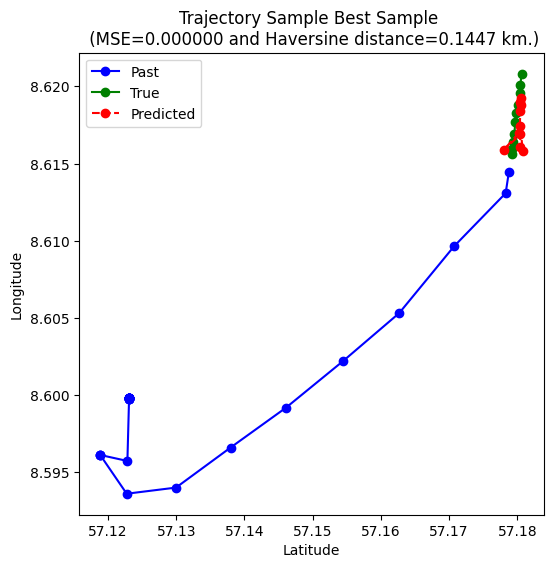


Plotting 3 samples from Q1 group:


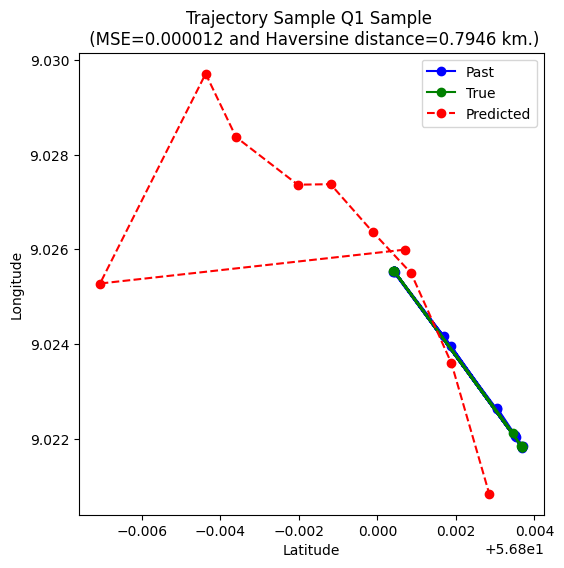

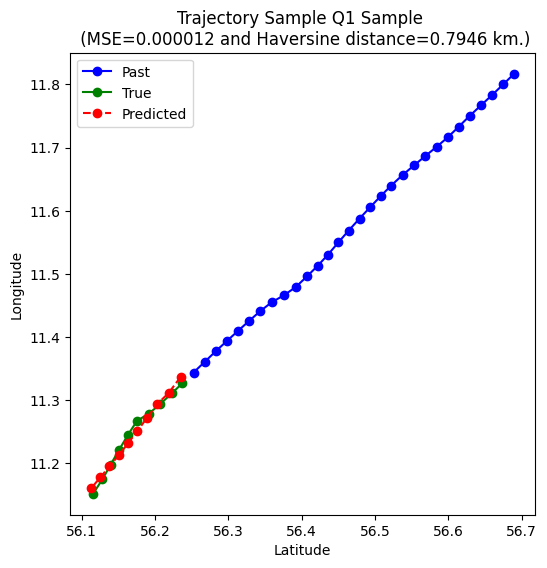

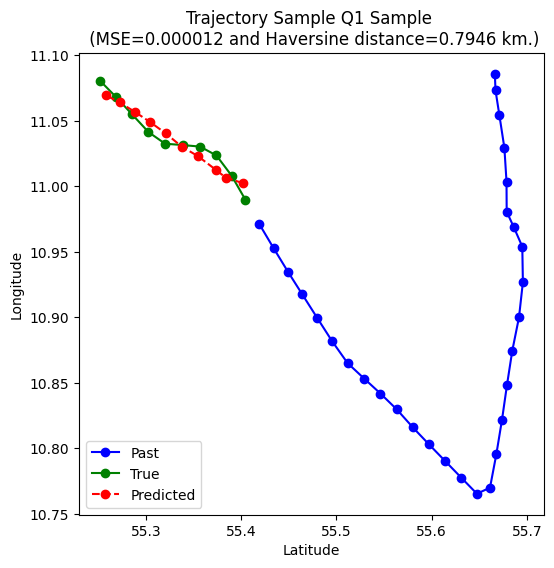


Plotting 3 samples from Median group:


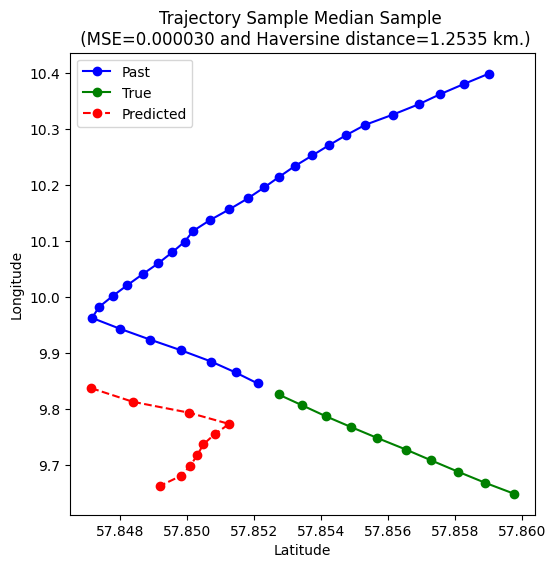

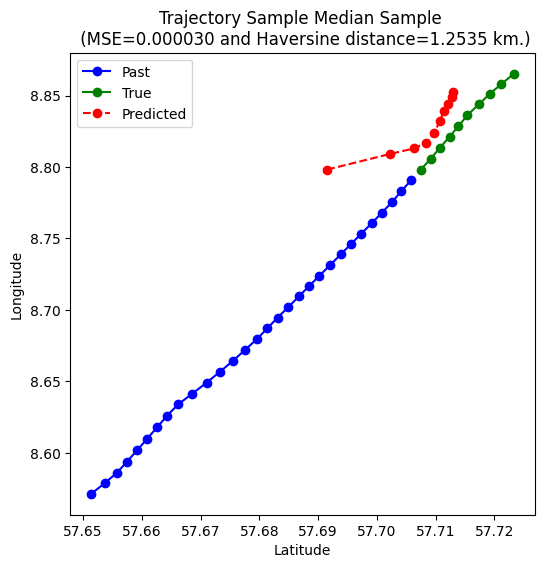

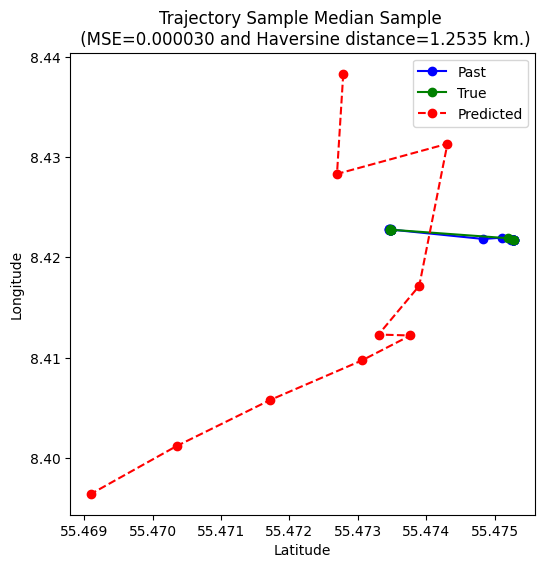


Plotting 3 samples from Q3 group:


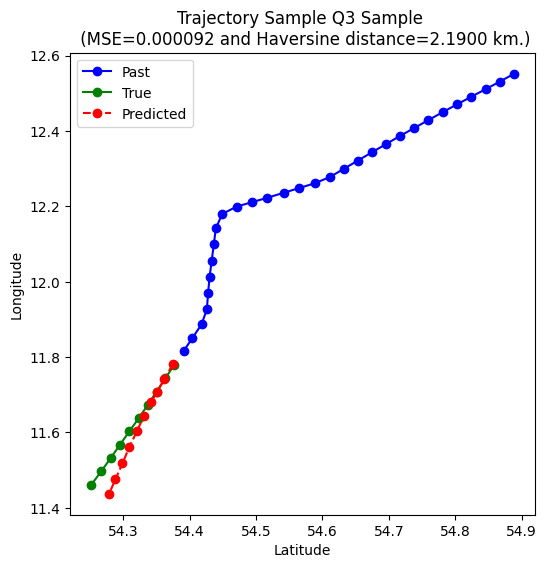

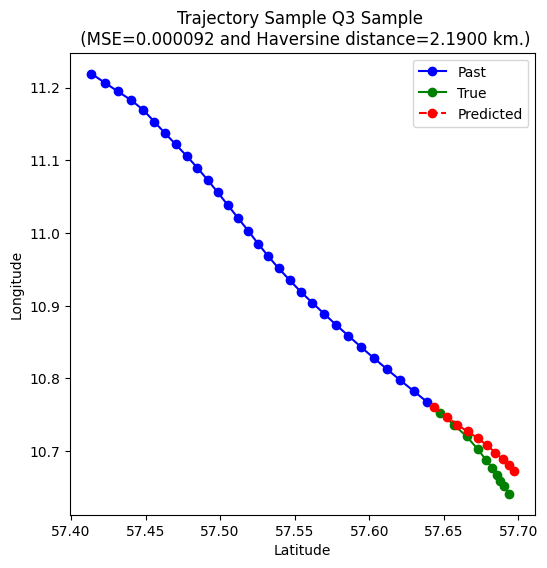

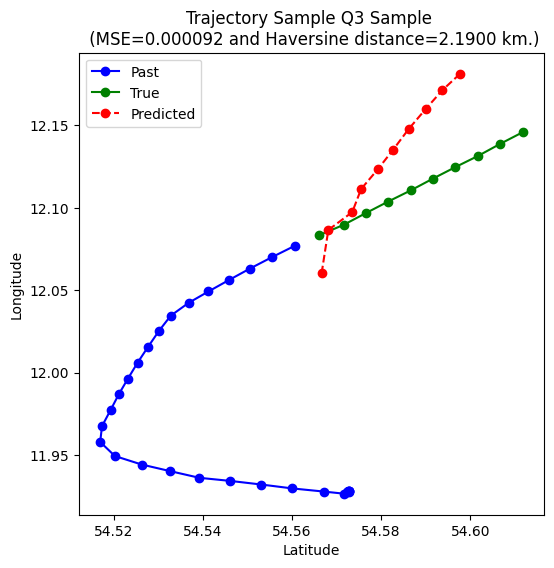


Plotting 3 samples from Worst group:


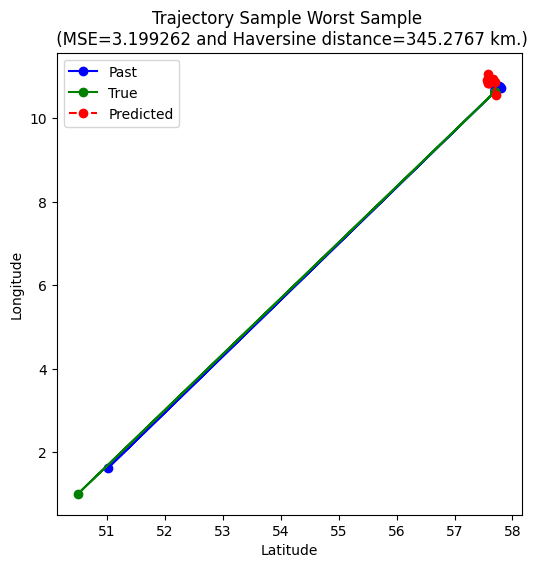

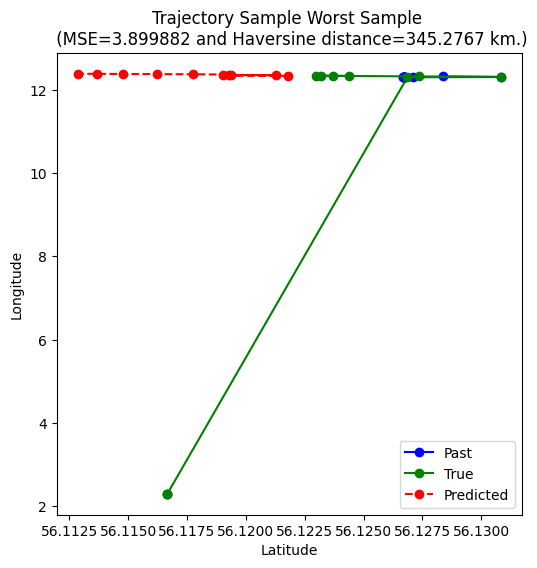

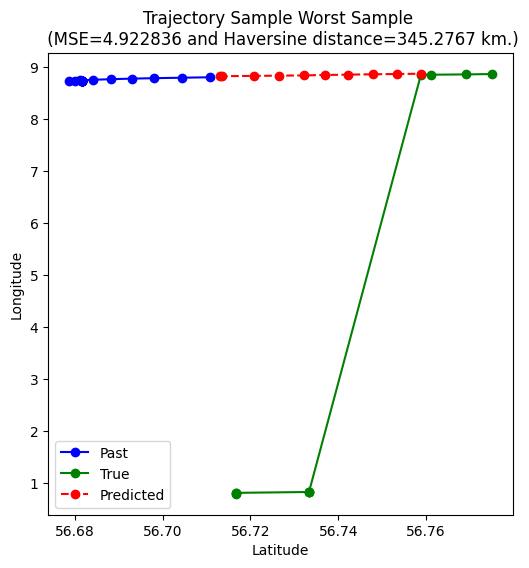

In [10]:
plot_samples(x,y, y_pred, all_mse, groups, group_means_dict, scaler=scaler)

### Results for the best model: Deep Autoregressive LSTM 2 (on the validation set)

In [11]:
file_path = metrics.pkl("deeper_autoreg_lstm_2", "val")

# Open the pickle file
with open(file_path, 'rb') as file:
    results = pickle.load(file)


In [12]:
all_mse = results["all_mse"]
x = results["x"]
y = results["y"]
y_pred = results["y_pred"]
n_samples = len(all_mse)
sorted_indices = np.argsort(all_mse)

In [13]:
percentiles = [10, 30, 50, 80, 90, 95, 99, 99.99, 100]
print("\nMSE percentile summary:\n")
for p in percentiles:
    threshold = np.percentile(all_mse, p)
    print(f"{p:>3}% of samples have MSE ≤ {threshold:.6f}")


MSE percentile summary:

 10% of samples have MSE ≤ 0.000006
 30% of samples have MSE ≤ 0.000014
 50% of samples have MSE ≤ 0.000029
 80% of samples have MSE ≤ 0.000128
 90% of samples have MSE ≤ 0.000316
 95% of samples have MSE ≤ 0.000660
 99% of samples have MSE ≤ 0.002172
99.99% of samples have MSE ≤ 0.312827
100% of samples have MSE ≤ 9.043043


In [14]:
scaler = load_scaler(filtered=True)

groups = {
    "Best": sorted_indices[:3],
    "Q1": sorted_indices[n_samples//4:n_samples//4+3],
    "Median": sorted_indices[n_samples//2:n_samples//2+3],
    "Q3": sorted_indices[3*n_samples//4:3*n_samples//4+3],
    "Worst": sorted_indices[-3:]
}

group_means_dict = {}

print("\n=== Haversine Distance Evaluation by Groups ===")

for group_name, indices in groups.items():
    group_means = []

    print(f"\n### {group_name} group ###")

    for idx in indices:

        y_true_scaled = y[idx]
        y_pred_scaled = y_pred[idx]


        y_true_unscaled = scaler.inverse_transform(y_true_scaled)
        y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

        # Compute Haversine
        dists_km, mean_hav_km = haversine_np(y_true_unscaled, y_pred_unscaled)

        # Save group mean
        group_means.append(mean_hav_km)

        # --- Pretty step-wise print for groups ---
        print(f"\nSample {idx} (MSE={all_mse[idx]:.6f}) – Haversine per step:")
        for step, d in enumerate(dists_km, start=1):
            print(f"  Step {step:02d} → {d:10.6f} km")

        print(f"  -> Mean Haversine for this sample: {mean_hav_km:.6f} km")

        group_means_dict[group_name] = group_means


=== Haversine Distance Evaluation by Groups ===

### Best group ###

Sample 13580 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.068811 km
  Step 02 →   0.134585 km
  Step 03 →   0.126003 km
  Step 04 →   0.151349 km
  Step 05 →   0.055563 km
  Step 06 →   0.064737 km
  Step 07 →   0.050344 km
  Step 08 →   0.022891 km
  Step 09 →   0.011926 km
  Step 10 →   0.062605 km
  -> Mean Haversine for this sample: 0.074881 km

Sample 62904 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.147275 km
  Step 02 →   0.084086 km
  Step 03 →   0.204412 km
  Step 04 →   0.189598 km
  Step 05 →   0.069135 km
  Step 06 →   0.006271 km
  Step 07 →   0.118385 km
  Step 08 →   0.133531 km
  Step 09 →   0.168344 km
  Step 10 →   0.119799 km
  -> Mean Haversine for this sample: 0.124084 km

Sample 87022 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.209583 km
  Step 02 →   0.057383 km
  Step 03 →   0.328291 km
  Step 04 →   0.234567 km
  Step 05 →   0.022864 km
  Step 06 →   0.038345 km
  St


Plotting 3 samples from Best group:


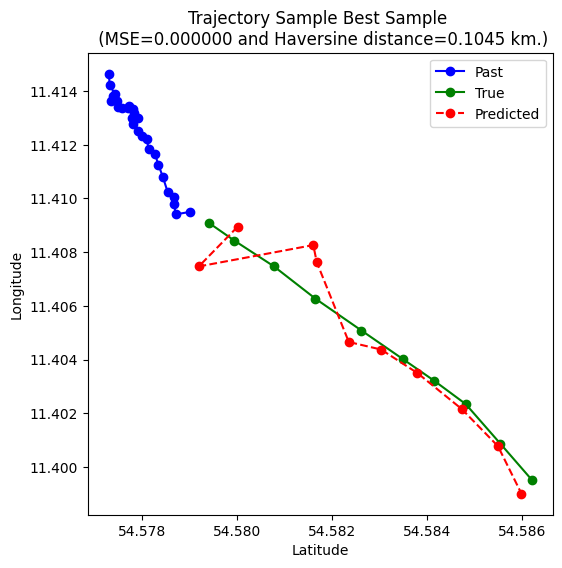

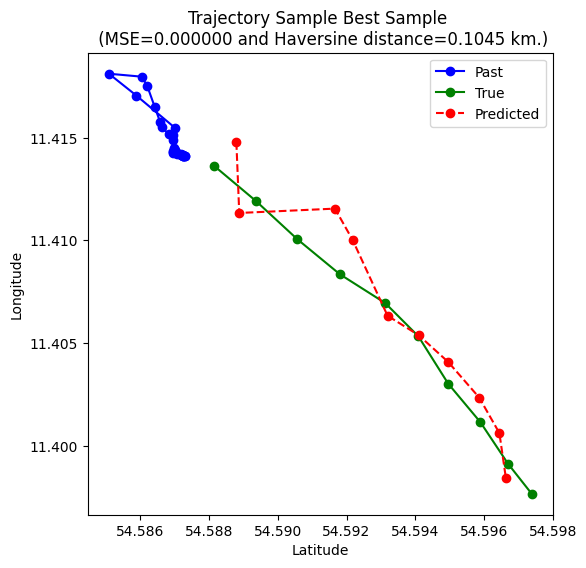

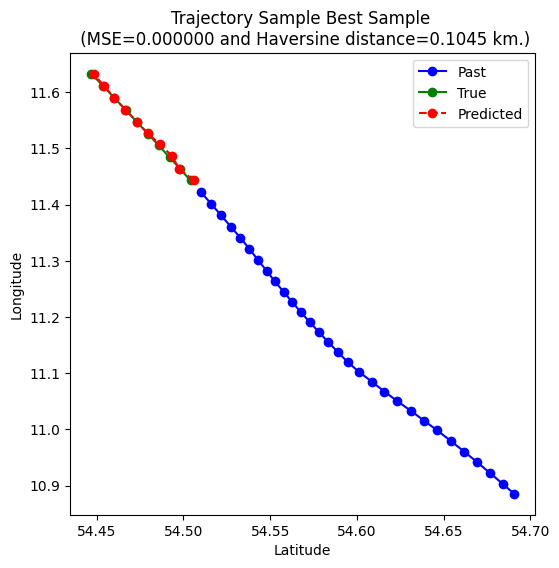


Plotting 3 samples from Q1 group:


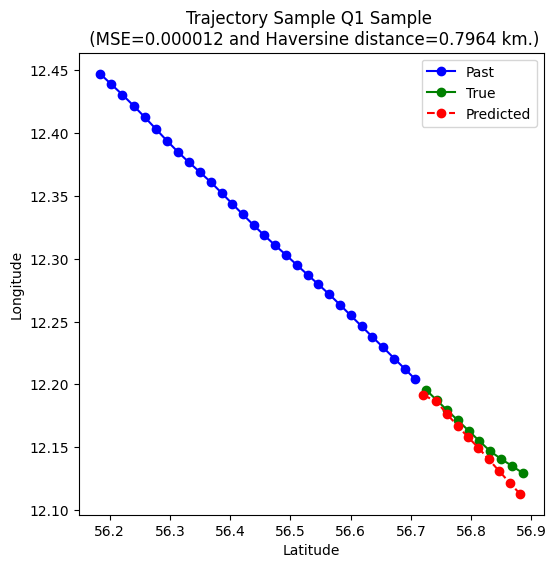

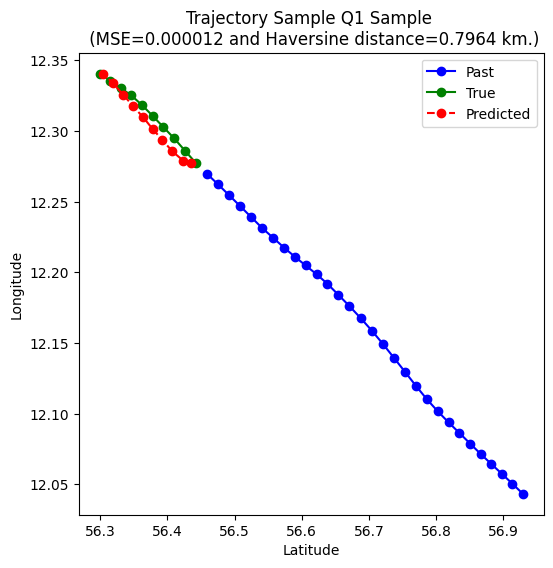

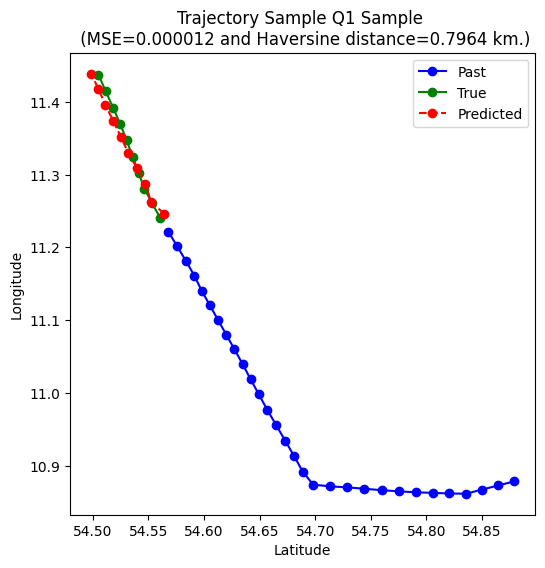


Plotting 3 samples from Median group:


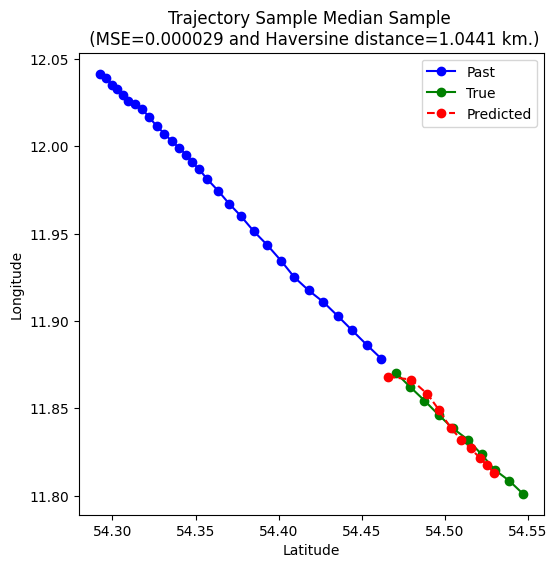

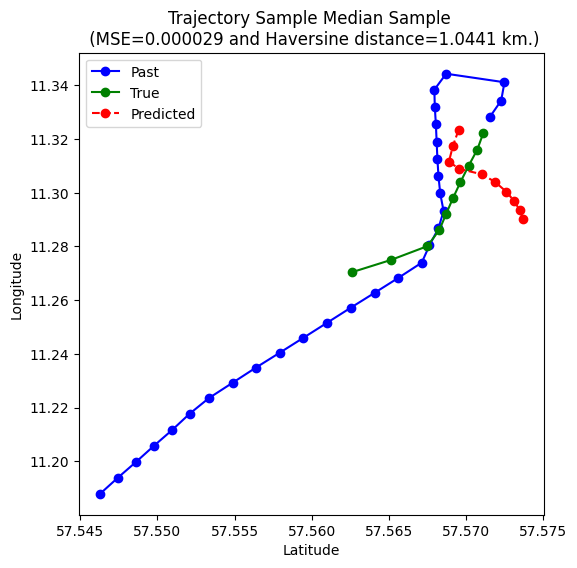

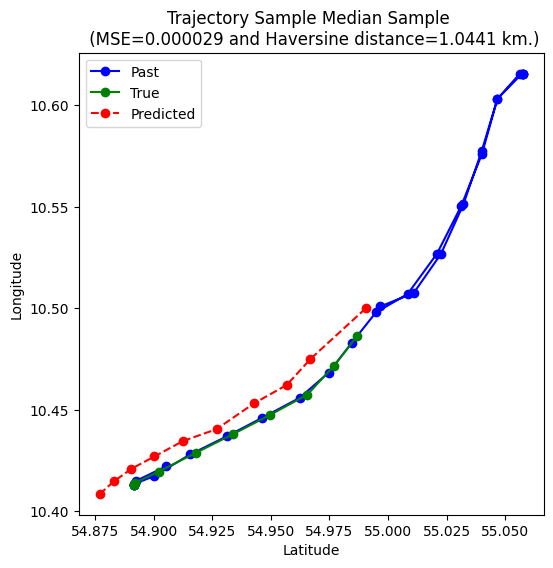


Plotting 3 samples from Q3 group:


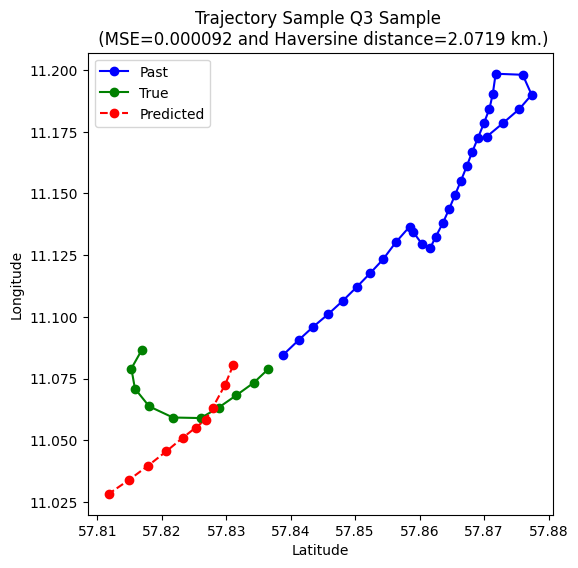

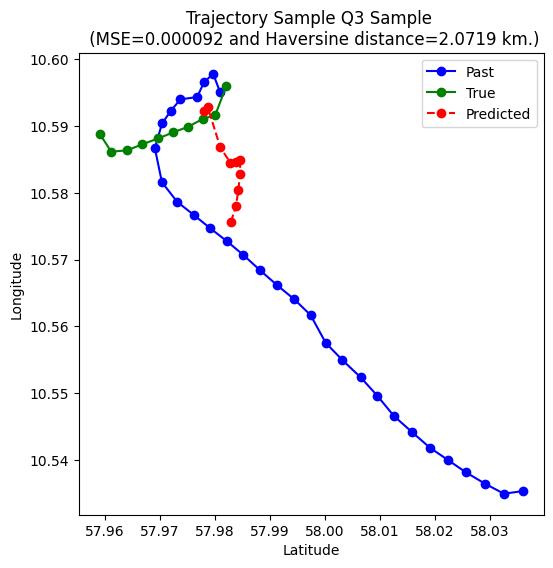

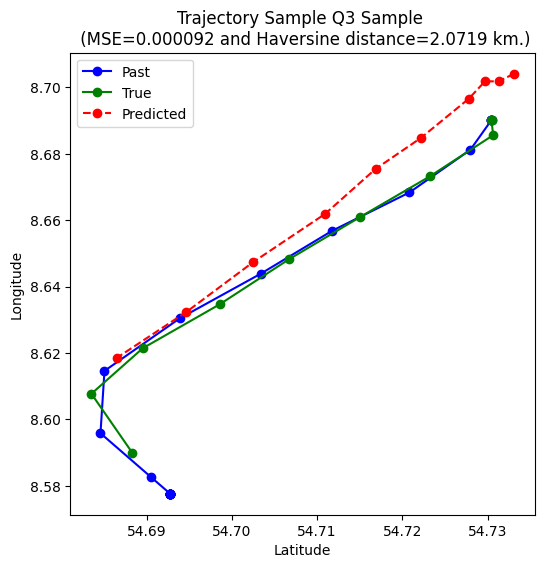


Plotting 3 samples from Worst group:


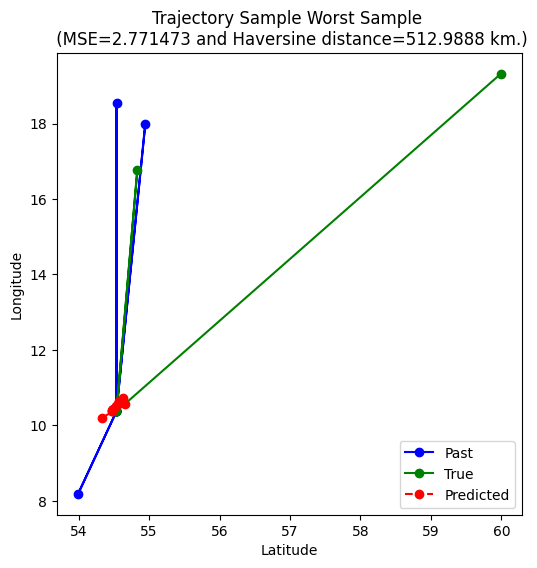

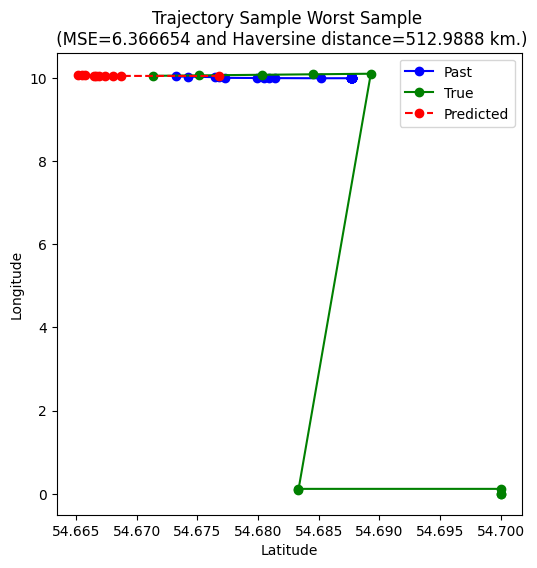

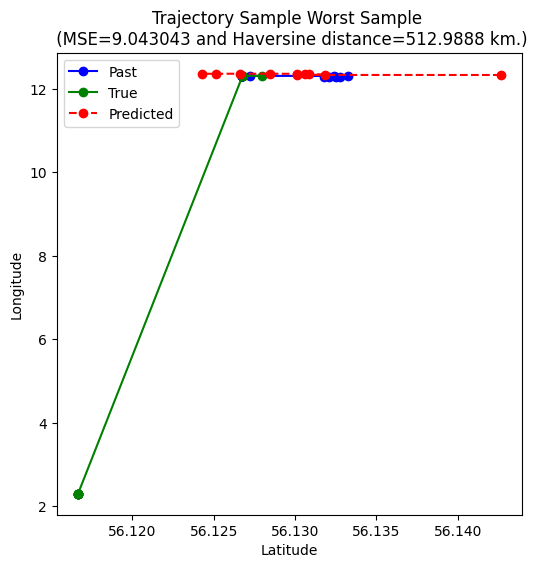

In [15]:
plot_samples(x,y, y_pred, all_mse, groups, group_means_dict, scaler=scaler)

### Results for the best transformer model: Deep Transformer (on the validation set)

In [17]:
file_path = metrics.pkl("deeper_transformer", "val")

# Open the pickle file
with open(file_path, 'rb') as file:
    results = pickle.load(file)


In [18]:
all_mse = results["all_mse"]
x = results["x"]
y = results["y"]
y_pred = results["y_pred"]
n_samples = len(all_mse)
sorted_indices = np.argsort(all_mse)

In [19]:
percentiles = [10, 30, 50, 80, 90, 95, 99, 99.99, 100]
print("\nMSE percentile summary:\n")
for p in percentiles:
    threshold = np.percentile(all_mse, p)
    print(f"{p:>3}% of samples have MSE ≤ {threshold:.6f}")


MSE percentile summary:

 10% of samples have MSE ≤ 0.000006
 30% of samples have MSE ≤ 0.000020
 50% of samples have MSE ≤ 0.000050
 80% of samples have MSE ≤ 0.000221
 90% of samples have MSE ≤ 0.000506
 95% of samples have MSE ≤ 0.000968
 99% of samples have MSE ≤ 0.002837
99.99% of samples have MSE ≤ 0.311381
100% of samples have MSE ≤ 8.987614


In [20]:
scaler = load_scaler(filtered=True)

groups = {
    "Best": sorted_indices[:3],
    "Q1": sorted_indices[n_samples//4:n_samples//4+3],
    "Median": sorted_indices[n_samples//2:n_samples//2+3],
    "Q3": sorted_indices[3*n_samples//4:3*n_samples//4+3],
    "Worst": sorted_indices[-3:]
}

group_means_dict = {}

print("\n=== Haversine Distance Evaluation by Groups ===")

for group_name, indices in groups.items():
    group_means = []

    print(f"\n### {group_name} group ###")

    for idx in indices:

        y_true_scaled = y[idx]
        y_pred_scaled = y_pred[idx]


        y_true_unscaled = scaler.inverse_transform(y_true_scaled)
        y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

        # Compute Haversine
        dists_km, mean_hav_km = haversine_np(y_true_unscaled, y_pred_unscaled)

        # Save group mean
        group_means.append(mean_hav_km)

        # --- Pretty step-wise print for groups ---
        print(f"\nSample {idx} (MSE={all_mse[idx]:.6f}) – Haversine per step:")
        for step, d in enumerate(dists_km, start=1):
            print(f"  Step {step:02d} → {d:10.6f} km")

        print(f"  -> Mean Haversine for this sample: {mean_hav_km:.6f} km")

        group_means_dict[group_name] = group_means


=== Haversine Distance Evaluation by Groups ===

### Best group ###

Sample 238271 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.106330 km
  Step 02 →   0.072141 km
  Step 03 →   0.054622 km
  Step 04 →   0.075494 km
  Step 05 →   0.071726 km
  Step 06 →   0.094429 km
  Step 07 →   0.065075 km
  Step 08 →   0.070389 km
  Step 09 →   0.048488 km
  Step 10 →   0.128305 km
  -> Mean Haversine for this sample: 0.078700 km

Sample 231624 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.020606 km
  Step 02 →   0.135043 km
  Step 03 →   0.070111 km
  Step 04 →   0.106533 km
  Step 05 →   0.157810 km
  Step 06 →   0.003847 km
  Step 07 →   0.060991 km
  Step 08 →   0.075995 km
  Step 09 →   0.098982 km
  Step 10 →   0.095106 km
  -> Mean Haversine for this sample: 0.082502 km

Sample 75928 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.051194 km
  Step 02 →   0.114700 km
  Step 03 →   0.039860 km
  Step 04 →   0.064873 km
  Step 05 →   0.095234 km
  Step 06 →   0.092955 km
  


Plotting 3 samples from Best group:


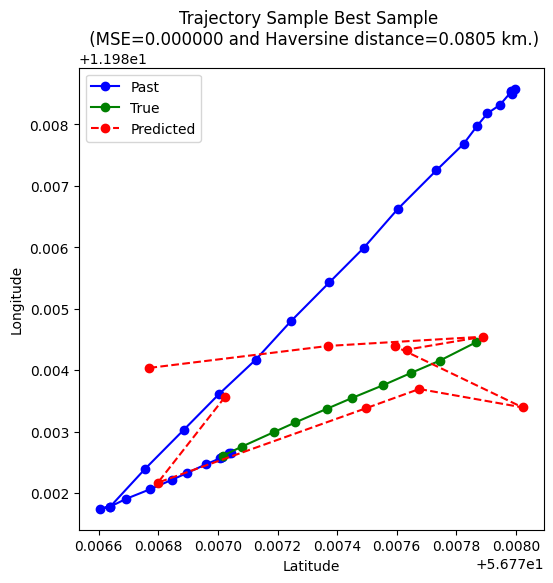

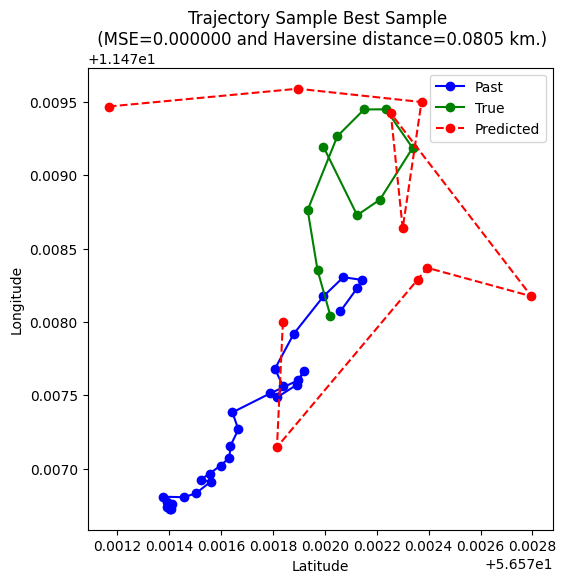

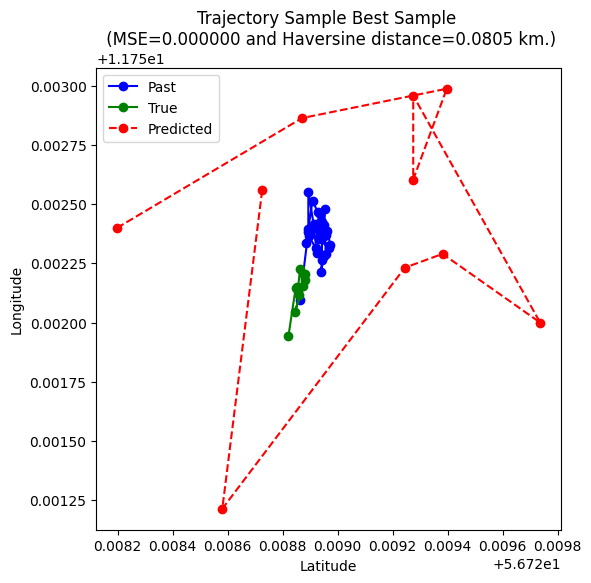


Plotting 3 samples from Q1 group:


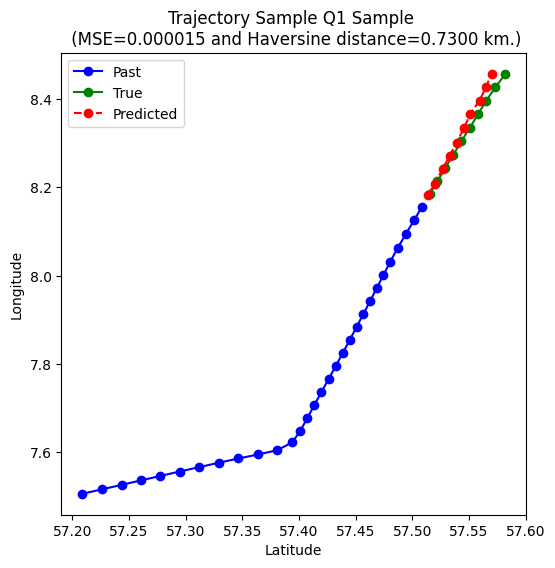

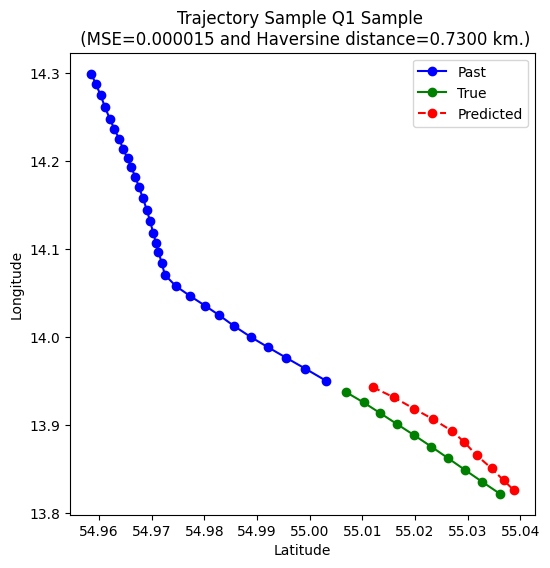

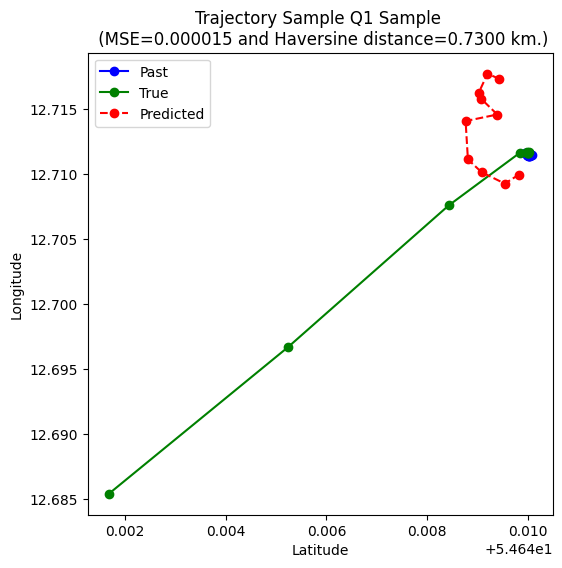


Plotting 3 samples from Median group:


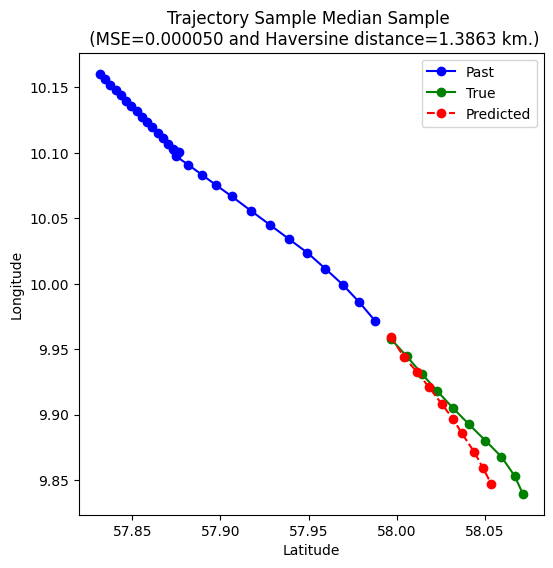

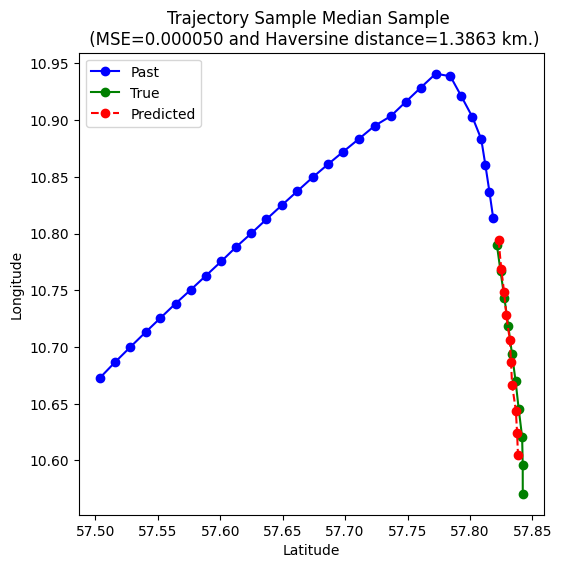

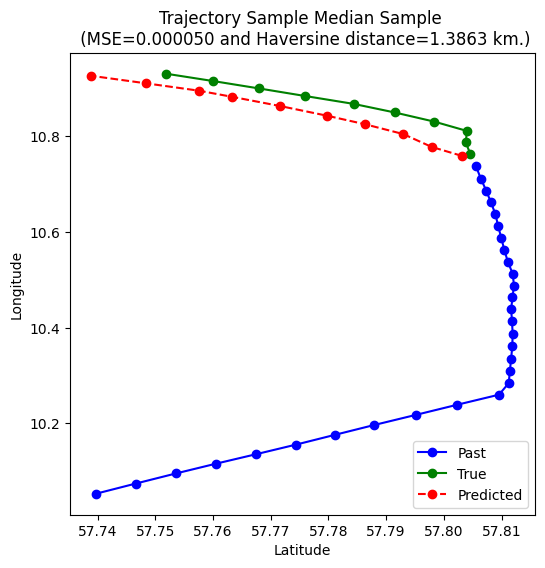


Plotting 3 samples from Q3 group:


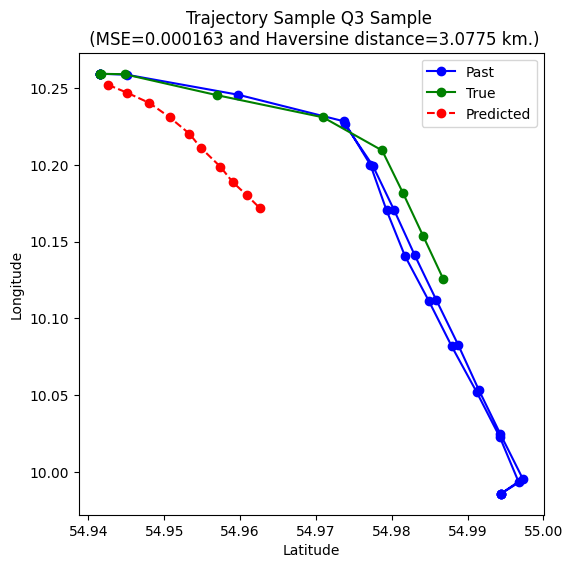

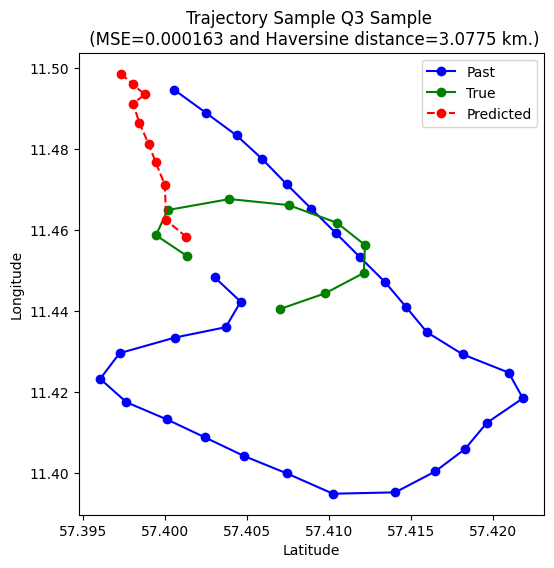

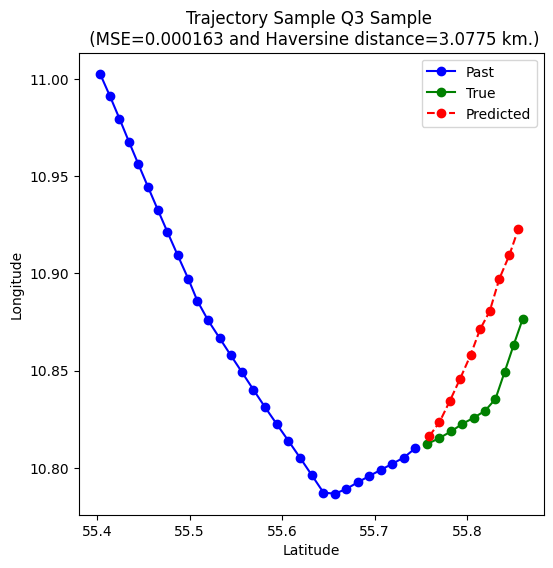


Plotting 3 samples from Worst group:


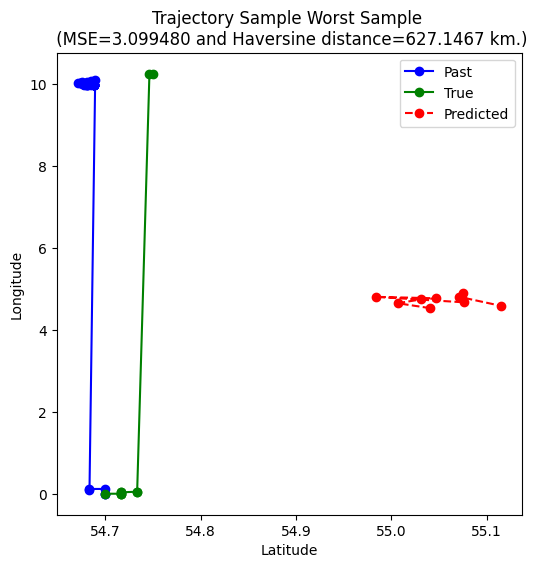

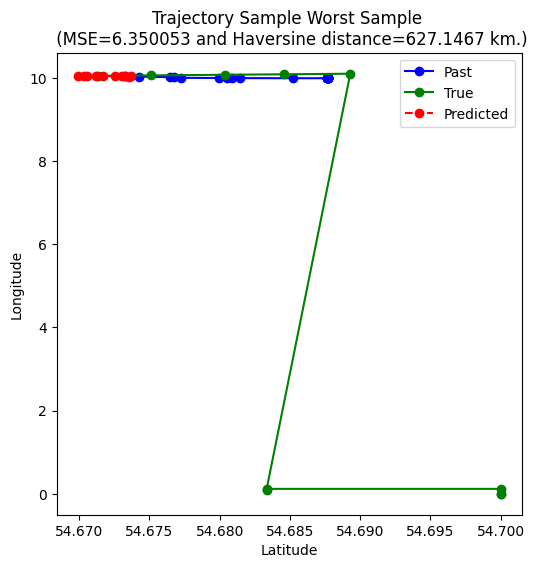

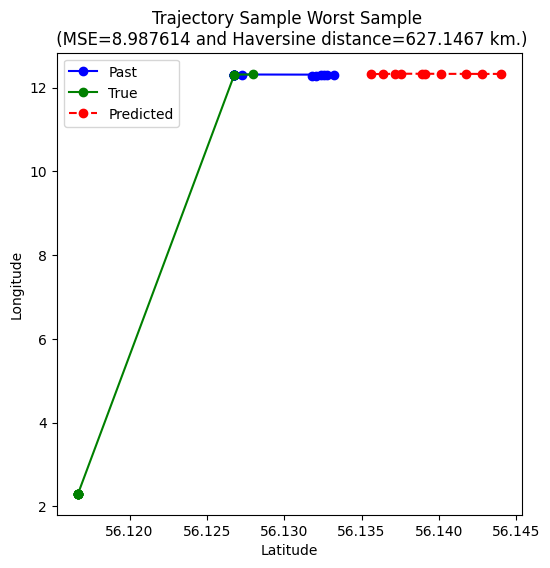

In [21]:
plot_samples(x,y, y_pred, all_mse, groups, group_means_dict, scaler=scaler)